## Brownian Motion Model

The Brownian Motion model is the first model we will take a look at. This is a simple model that will serve as a benchmark for further experiments. Note that in this particular model, we have access to the closed form distributions of the posterior. Since our method is an approximation method, it will serve as a reasonable sanity check and debugging tool to ensure that our method is not only technically sound, but also empirically verifiable. The model is defined below, where each sample is obtained identically and independentally distributed from the distribution on the right hand side. Here we only have a single observation $y_t$ and we have a constant $dt$ through which we never need to take derivatives. Note that with $\pi(x_0) \propto 1$, we may condition on $y_0$ and obtain $x_0 \mid y_0 \sim \N(y_0, \tau^2)$.

$$\begin{aligned}
x_0 & \sim \pi(x_0) \\
x_t & \sim \mathcal{N}(x_{t-1} + \mu dt, \sigma^2 dt) \\
y_t & \sim \mathcal{N}(x_t, \tau^2).
\end{aligned}$$

Text(0.5, 1.0, 'Latent Variable(x_state) and Observation(y_meas)')

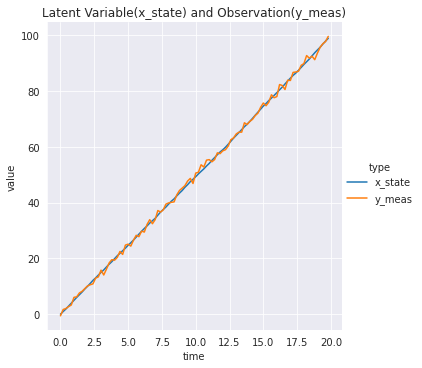

In [16]:
import numpy as np
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import jax.random as random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import projplot as pjp

# module containing pfjax (for now)
import pfjax as pf
# utility for plotting
from pfjax.models import BMModel

# initial key for random numbers
key = random.PRNGKey(0)
sns.set_style("darkgrid")
# parameter values
mu = 5.
sigma = .2
tau = 1.
theta = np.array([mu, sigma, tau])

# data specification
dt = .2
n_obs = 100
x_init = jnp.array([0.])

# simulate data
bm_model = BMModel(dt=dt)
key, subkey = random.split(key)
y_meas, x_state = pf.simulate(bm_model, key, n_obs, x_init, theta)

# plot data
plot_df = (pd.DataFrame({"time": jnp.arange(n_obs) * dt,
                         "x_state": jnp.squeeze(x_state),
                         "y_meas": jnp.squeeze(y_meas)})
           .melt(id_vars="time", var_name="type"))
sns.relplot(
    data=plot_df, kind="line",
    x="time", y="value", hue="type"
)
plt.title("Latent Variable(x_state) and Observation(y_meas)")


One of the advantages for this model is that we may compute the exact likelihood because of the closed form of the posterior. In this case, we implement the computation of the closed form posterior below.

In [17]:
@jax.jit
def bm_loglik(y_meas, dt, theta):
    """
    Exact loglikelihood of the BM model.
    """
    mu = theta[0]
    sigma2 = theta[1] * theta[1]
    tau2 = theta[2] * theta[2]
    n_obs = y_meas.shape[0]-1  # conditioning on y_0
    t_meas = jnp.arange(1, n_obs+1) * dt
    Sigma_y = sigma2 * jax.vmap(lambda t: jnp.minimum(t, t_meas))(t_meas) + \
        tau2 * (jnp.ones((n_obs, n_obs)) + jnp.eye(n_obs))
    mu_y = y_meas[0] + mu * t_meas
    return jsp.stats.multivariate_normal.logpdf(jnp.squeeze(y_meas[1:]), mu_y, Sigma_y)


bm_loglik(y_meas, dt, np.array([5, 1.2, 0]))

DeviceArray(-326.22656, dtype=float32)

Text(0.5, 0.98, 'Projection Plots using Closed-Form Latents')

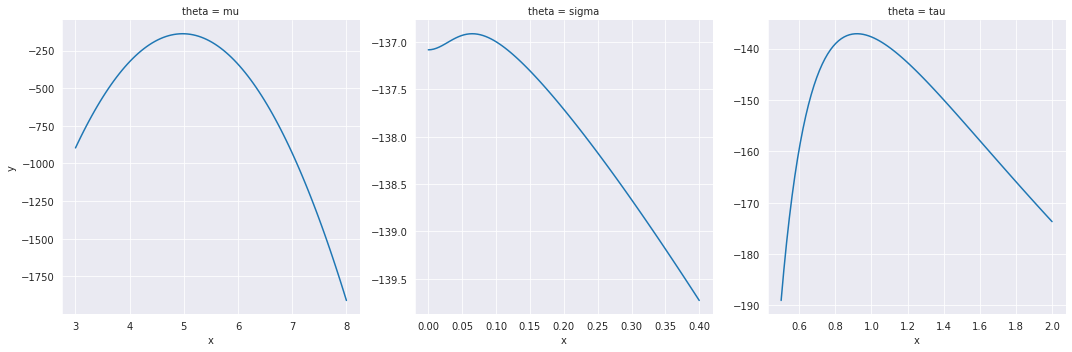

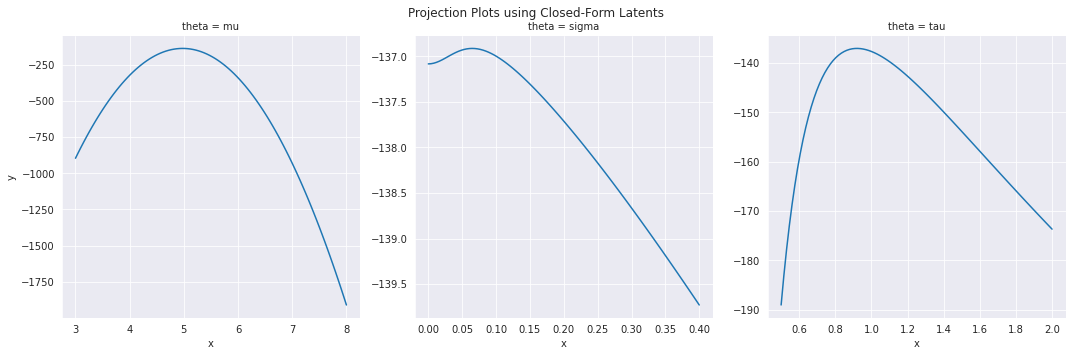

In [18]:
def proj_data(fun, x, x_lims, x_names, n_pts=100):
    """
    Wrapper for projxvals and projdata.
    """
    xvals = pjp.projxvals(x, x_lims, n_pts)
    return pjp.projdata(fun, xvals, x_names, is_vectorized=False)

# plot exact likelihood
theta_lims = np.array([[3., 8.], [0., .4], [.5, 2]])
#theta_lims = np.array([[3., 8.], [.194, .195], [0, 10]])
theta_names = ["mu", "sigma", "tau"]
n_pts = 100

# calculate projection plot
plot_df = proj_data(lambda th: bm_loglik(y_meas, dt, th),
                    theta, theta_lims, theta_names, n_pts=n_pts)

rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Projection Plots using Closed-Form Latents')



Given that the algorithm we wish to use is gradient ascent (or descent on the negative log likeloood), we note that these plots appear to be amenable to gradient based optimization.

We would also like to now plot the particle filter log likelihood in the same domain for the parameters. Here, we are using the estimated latent variables compared to the exact ones and as a result, we would expect to see more noise in the parameter values.

Text(0.5, 0.98, 'Projection Plots using Estimated Latents')

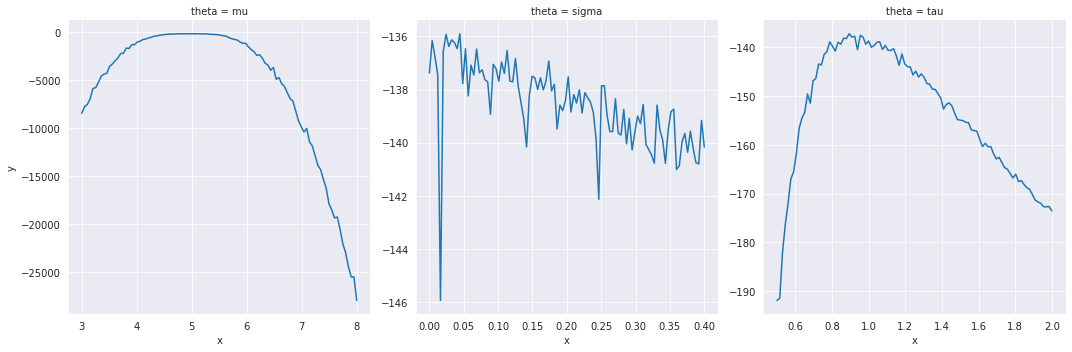

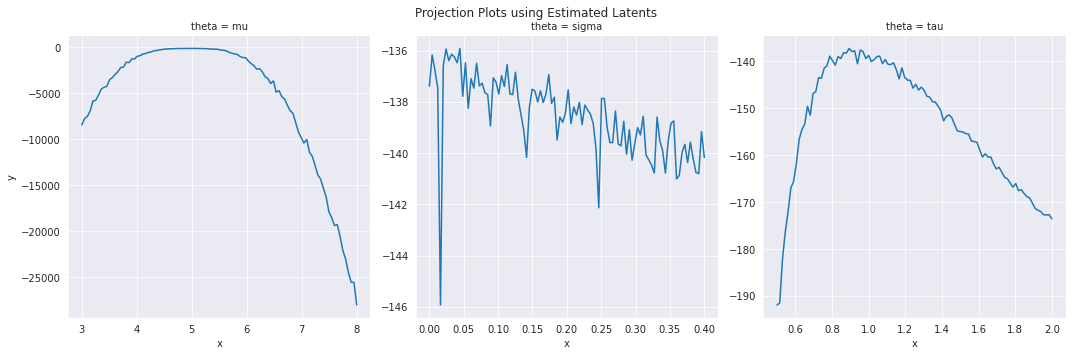

In [19]:
theta_lims = np.array([[3., 8.], [0., .4], [.5, 2]])
theta_names = ["mu", "sigma", "tau"]
n_pts = 100

@jax.jit
def bm_pflik(theta):
    temp = pf.particle_filter(theta=theta, model=bm_model, y_meas=y_meas,
                              n_particles=100, key=key)
    return pf.particle_loglik(temp['logw'])


plot_df = proj_data(bm_pflik,
                    theta, theta_lims, theta_names)

rp = sns.relplot(
    data=plot_df, kind="line",
    x="x", y="y", col="theta",
    col_wrap = 3,
    facet_kws=dict(sharex=False, sharey=False)
)
rp.fig.subplots_adjust(top=0.9) # adjust the Figure in rp
rp.fig.suptitle('Projection Plots using Estimated Latents')


In [22]:
import optax
from functools import partial
def update_params(params, subkey, opt_state, grad_fun=None, n_particles=100, y_meas=None, model=None, learning_rate=0.01, mask=None,
                  optimizer=None):
    '''
    Args:
        params: A jnp.array that represents the values of the parameters before the gradient update.
        subkey: The subkey for the current loop iteration.
        opt_state: The optimizer state of the parameters.
        grad_fun: The function with which to take the gradients with respect to.
        n_particles: The number of particles for the particle filter.
        y_meas: The observed data `y_meas`
        model: The model class which has the predefined methods to run the forward pass.
        learning_rate: The learning rate for the stochastic optimization method.
        mask: A mask (0 or 1 vector) which represents the parameters that we wish to update in an iteration.
        optimizer: The choice of stochastic optimizer (e.g. Adam/Adagrad)
    
    Returns:
        params: The updated parameters at the end of the stochastic optimization step.
    '''
    # First we obtain the gradients of the gradient function with respect to the `grad_fun`.
    params_update = jax.grad(grad_fun, argnums=0)(
        params, subkey, n_particles, y_meas, model)
    # Updating the params with respect to the mask.
    params_update = jnp.where(mask, params_update, 0)
    # Applying the updates to the parameters except for those that are masked.
    updates, opt_state = optimizer.update(params_update, opt_state)
    return optax.apply_updates(params, updates) 


def stoch_opt(model, params, grad_fun, y_meas, n_particles=100, iterations=10,
              learning_rate=0.01, key=1, mask=None):
    """
    Args:
        model: The model class for which all of the functions are defined.
        params: A jnp.array that represents the initial values of the parameters.
        grad_fun: The function which we would like to take the gradient with respect to.
        y_meas: The measurements of the observations required for the particle filter.
        n_particles: The number of particles to use in the particle filter.
        iterations: The number of iterations to run the gradient descent for.
        learning_rate: The learning rate for the gradient descent algorithm.
        key: The key required for the prng.
        mask: The mask over which dimensions we would like to perform the optimization.
    
    Returns:
        params: The final value of the parameters.
    """
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(params)
    # Partially evaluate the function with respect to all of the parameters that do not change over time.
    partial_update_params = partial(update_params, n_particles=n_particles, y_meas=y_meas,
                                    model=model, learning_rate=learning_rate, mask=mask, grad_fun=grad_fun, 
                                    optimizer=optimizer)
    # JIT the update step.
    update_fn = jax.jit(partial_update_params, donate_argnums=(0,))
    # Every iteration, the keys must be split to obtain several subkeys for which we have to take the update step.
    keys = random.split(key, iterations)
    for subkey in keys:
        params = update_fn(params, subkey, opt_state)
    return params 
    

def particle_neg_loglik(theta, key, n_particles, y_meas, model):
    """
    Evaluate the bootstrap particle filter estimate of the negative log-likelihood at parameter values \theta. Runs the particle filter for each timestep in y_meas and sums the log-weights for each particle
    Args:
        theta: A `jnp.array` that represents the values of the parameters on the log scale.
        key: The key required for the prng.
        n_particles: The number of particles to use in the particle filter.
        y_meas: The measurements of the observations required for the particle filter.
    Returns:
        Estimate of the negative log-likelihood evaluated at \theta. 
    """
    theta_reg = jnp.array([theta[0], jnp.exp(theta[1]), jnp.exp(theta[2])])
    ret = pf.particle_filter(model, key, y_meas, theta_reg, n_particles)
    sum_particle_lweights = pf.particle_loglik(ret['logw'])
    return -sum_particle_lweights


def hessian_averaging_alg(optima, key, grad_fun, y_meas, model, iterations=100, n_particles=500):
    hessian_fn = jax.jit(jax.jacfwd(jax.jacrev(partial(grad_fun, n_particles=n_particles, model=model))))
    keys = random.split(key, iterations)
    hess = jax.vmap(lambda i: hessian_fn(optima, keys[i], y_meas=y_meas))(jnp.arange(iterations))
#     hess = hessian_fn(optima, key, n_particles=n_particles, y_meas=y_meas, model=model)
#     keys = random.split(key, iterations)
#     j = 2
#     for i in range(len(keys)):
#         # while(jnp.all(jnp.linalg.eigvals(hess) >= 0)): 
#         new_hess = hessian_fn(optima, keys[i], n_particles=n_particles, y_meas=y_meas, model=model)
#         hess = (((j - 1) / (j)) * hess) + ((1 / j) * new_hess)
#         j += 1
    return hess 

Now, we run the stochastic optimization on the model for 1000 iterations to see whether the local optima that we initialize the model to is stable enough for the model to not diverge from there. Please note that we may also increase the number of particles greatly to improve the efficacy of the method given that our approximation is exact as the number of particles approaches infinity.

In [23]:
params = stoch_opt(bm_model, jnp.array([5.0, jnp.log(0.2), jnp.log(1.0)]), particle_neg_loglik, y_meas, key=key, learning_rate=0.001, iterations=1000, n_particles=500,
         mask=np.array([1,1,1]))
params_reg = jnp.array([params[0], jnp.exp(params[1]), jnp.exp(params[2])])
params_reg

DeviceArray([4.9780016 , 0.07461505, 0.91028327], dtype=float32)

Now, we average the hessians iteration over iteration to observe whether they eventually converge to a hessian that is positive semidefinite. This is the first method of trying to establish a usable variance estimate for our method.

In [24]:
hess = hessian_averaging_alg(params, key, particle_neg_loglik, y_meas, bm_model,
                            iterations=10, n_particles=10)

TypeError: Argument '<pfjax.models.bm_model.BMModel object at 0x7f7518cb69d0>' of type <class 'pfjax.models.bm_model.BMModel'> is not a valid JAX type.

In [13]:
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print(temp)

Unfortunately, we notice that this does not yield a PSD hessian even after 1000 iterations. Therefore, we are not able to obtain a variance estimate here. Next, we shall try to add a value to the diagonal and use that as our estimate. In order for this method to be effective, we try to add the smallest value we possibly can to the diagonal of the hessian.

In [11]:
hessian_fn = jax.jacfwd(jax.jacrev(particle_neg_loglik))
additive_const = 1e-2
hess = hessian_fn(params, key, n_particles=1000, y_meas=y_meas, model=bm_model)
var_hat = jnp.linalg.inv(hess)
temp = jnp.all(jnp.linalg.eigvals(var_hat) >= 0)
print("Original Hessian estimate is positive semidefinite: ", temp)
var_hat = np.array(var_hat)
var_hat[np.diag_indices_from(var_hat)] += additive_const
temp = jnp.all(jnp.linalg.eigvals(jnp.array(var_hat)) >= 0)
print("New Hessian Estimate obtained by adding {0} to original is psd: ".format(additive_const), temp)


Original Hessian estimate is positive semidefinite:  False
New Hessian Estimate obtained by adding 0.01 to original is psd:  True


Now, given that this method worked, we generate posteriors for each of our parameters, that is, $\tau, \mu, \sigma$

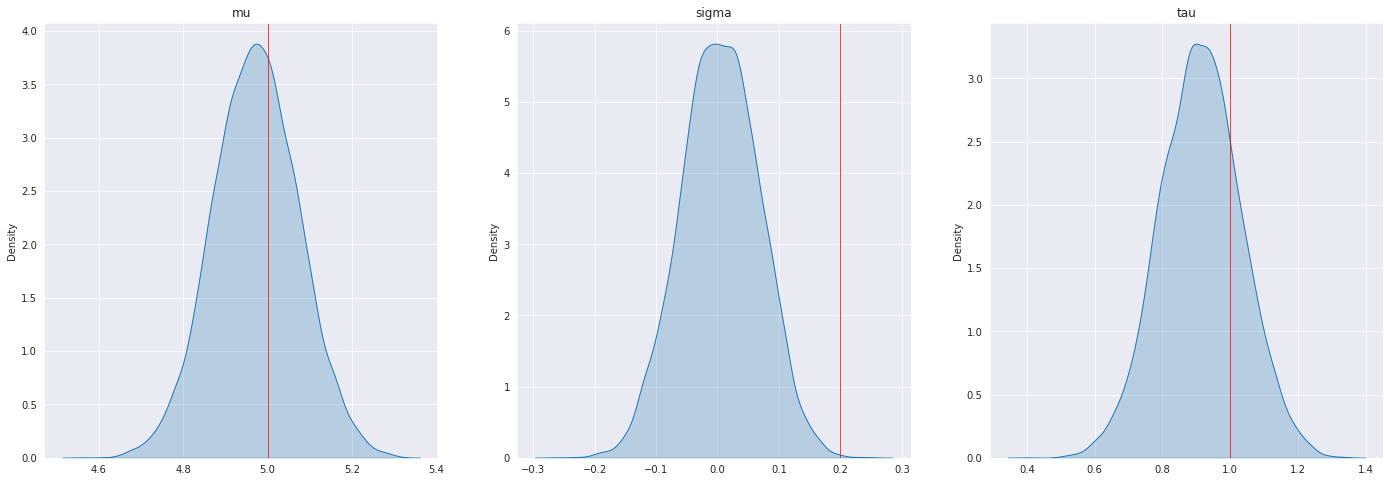

In [43]:
mle_samples = random.multivariate_normal(key=key, mean=params, cov=var_hat, shape=(10_000, ))

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
for ind, _ax in enumerate(ax.flatten()):
    sns.kdeplot(mle_samples[:, ind], ax = _ax, shade = True).set_title(theta_names[ind])
    _ax.axvline(theta[ind], color='red', lw = 0.75)

plt.show()